In [5]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt

In [6]:
mesh_grid = np.meshgrid(np.arange(0, 129, 8), np.arange(0, 129, 8))

In [7]:
coors = np.concatenate([mesh_grid[0][..., np.newaxis], mesh_grid[1][..., np.newaxis]], axis=2)

In [8]:
coors = coors.reshape(-1, 2)

In [9]:
points = coors

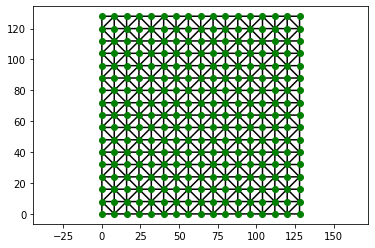

In [10]:
tris = Delaunay(coors)
plt.triplot(points[:, 0], points[:, 1], tris.simplices.copy(), c='black')
plt.plot(points[:, 0], points[:, 1], 'o', c='green')
plt.axis('equal')
plt.show()

In [ ]:
tris.simplices.shape

In [ ]:
from utils.solve_DLT import *
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
mesh_flow = torch.tensor([(0, 0), (0, 0), (0, 0), (0, 0), (-100, -100), (0, 0), (0, 0), (0, 0), (0, 0)], dtype=torch.float, device=torch.device("cpu")).permute(1, 0).reshape(2, 3, 3).unsqueeze(0)
mesh_flow = mesh_flow_upsampling(mesh_flow, (3, 3), (9, 9), (1280, 1280), 1, torch.device("cpu"))
# b, c = solve_mesh_flow_DLT_triangle(mesh_flow, torch.device("cpu"), (160, 160), (1280, 1280))

In [ ]:
mesh_flow

In [ ]:
coors = mesh_flow.squeeze(0).permute(1, 2, 0).numpy()
print(coors.shape)
plt.figure()
plt.scatter(coors[:, 0],coors[:, 1])

In [ ]:
print(origin_mesh_grid.shape)
print(mesh_flow.shape)

In [ ]:
image_size = (1280, 1280)
patch_size = (160, 160)
device = torch.device("cpu")
from scipy.spatial import Delaunay
batch_size = mesh_flow.shape[0]
mesh_grid_X, mesh_grid_Y = torch.meshgrid(torch.arange(start=0, end=image_size[0] + 1, step=patch_size[0], dtype=torch.float, device=device),
    torch.arange(start=0, end=image_size[1] + 1, step=patch_size[1], dtype=torch.float, device=device,),
    indexing="ij",
)
mesh_grid = torch.cat([mesh_grid_X.unsqueeze(0), mesh_grid_Y.unsqueeze(0)], dim=0)
mesh_grid_flat = mesh_grid.permute(1, 2, 0).reshape(-1, 2)
tris = Delaunay(mesh_grid_flat.cpu().numpy())
tris_samples_indices = torch.from_numpy(tris.simplices).type(torch.int64)
origin_tris_samples = mesh_grid_flat[tris_samples_indices].unsqueeze(0).expand(batch_size, -1, -1, -1)
origin_mesh_grid = torch.cat([mesh_grid_X.unsqueeze(0), mesh_grid_Y.unsqueeze(0)], dim=0).unsqueeze(0).expand(batch_size, -1, -1, -1)
warped_mesh_grid = (origin_mesh_grid + mesh_flow).permute(0, 2, 3, 1).reshape(batch_size, -1, 2)

In [ ]:
warped_tris_samples = warped_mesh_grid[:, tris_samples_indices, :]
solved_matrices = solve_affine_DLT(warped_tris_samples.reshape(-1, 3, 2), origin_tris_samples.reshape(-1, 3, 2), device=device)

points_grid = torch.meshgrid(torch.arange(start=0.5, end=image_size[0], step=1, dtype=torch.float, device=device), \
    torch.arange(start=0.5, end=image_size[1], step=1, dtype=torch.float, device=device), indexing='xy')
points_grid = torch.cat([points_grid[0].unsqueeze(2), points_grid[1].unsqueeze(2)], dim=2).unsqueeze(0).expand(origin_tris_samples.reshape(-1, 3, 2).shape[0], -1, -1, -1)

def GetCross(point1, point2, points_grid, mesh_grid):
    cross_product = (mesh_grid[:, 0:1, point2:point2 + 1, 0] - mesh_grid[:, 0:1, point1:point1 + 1, 0]) * (points_grid[:, :, :, 1] - mesh_grid[:, 0:1, point1:point1 + 1, 1]) - \
            (points_grid[:, :, :, 0] - mesh_grid[:, 0:1, point1:point1 + 1, 0]) * (mesh_grid[:, 0:1, point2:point2 + 1, 1] - mesh_grid[:, 0:1, point1:point1 + 1, 1])
    return cross_product

warped_tris_samples = warped_tris_samples.reshape(-1, 1, 3, 2)
cross12 = GetCross(0, 1, points_grid, warped_tris_samples)
cross23 = GetCross(1, 2, points_grid, warped_tris_samples)
cross31 = GetCross(2, 0, points_grid, warped_tris_samples)
points_grid_mask = torch.bitwise_and((cross12 * cross23) >= 0, (cross23 * cross31) >= 0,).float()
# For Test
print(points_grid_mask.shape)
mask_value = (torch.arange(0, 128, 1, device=device) * 2).unsqueeze(1).unsqueeze(2)
tris_map = (mask_value * points_grid_mask).sum(dim=0)
im = transforms.ToPILImage()(tris_map)
im.save("tris_map.jpg")

In [ ]:
a = torch.arange(12).reshape(2, 3, 2)

In [ ]:
a

In [ ]:
torch.flip(a, dims=(2,))

In [ ]:
warped_mesh_grid.shape

In [ ]:
coors = warped_mesh_grid.squeeze(0).numpy()
print(coors.shape)
plt.figure()
plt.scatter(coors[:, 1],coors[:, 0])

In [ ]:
def solve_mesh_flow_DLT_triangle(mesh_flow: torch.Tensor, device: torch.device, patch_size: Tuple[int], image_size: Tuple[int]) -> Tuple[torch.Tensor]:
    # TODO: In future development, Delaunay mesh calculation should be completed outside the function
    from scipy.spatial import Delaunay
    batch_size = mesh_flow.shape[0]
    mesh_grid_X, mesh_grid_Y = torch.meshgrid(torch.arange(start=0, end=image_size[0] + 1, step=patch_size[0], dtype=torch.float, device=device),
        torch.arange(start=0, end=image_size[1] + 1, step=patch_size[1], dtype=torch.float, device=device,),
        indexing="xy",
    )
    mesh_grid = torch.cat([mesh_grid_X.unsqueeze(0), mesh_grid_Y.unsqueeze(0)], dim=0)
    mesh_grid_flat = mesh_grid.permute(1, 2, 0).reshape(-1, 2)
    tris = Delaunay(mesh_grid_flat.cpu().numpy())
    tris_samples_indices = torch.from_numpy(tris.simplices).type(torch.int64)
    origin_tris_samples = mesh_grid_flat[tris_samples_indices].unsqueeze(0).expand(batch_size, -1, -1, -1)
    origin_mesh_grid = torch.cat([mesh_grid_X.unsqueeze(0), mesh_grid_Y.unsqueeze(0)], dim=0).unsqueeze(0).expand(batch_size, -1, -1, -1)
    warped_mesh_grid = (origin_mesh_grid + mesh_flow).permute(0, 2, 3, 1).reshape(batch_size, -1, 2)
    warped_tris_samples = warped_mesh_grid[:, tris_samples_indices, :]
    solved_matrices = solve_affine_DLT(warped_tris_samples.reshape(-1, 3, 2), origin_tris_samples.reshape(-1, 3, 2), device=device)

    points_grid = torch.meshgrid(torch.arange(start=0.5, end=image_size[0], step=1, dtype=torch.float, device=device), \
        torch.arange(start=0.5, end=image_size[1], step=1, dtype=torch.float, device=device), indexing='xy')
    points_grid = torch.cat([points_grid[0].unsqueeze(2), points_grid[1].unsqueeze(2)], dim=2).unsqueeze(0).expand(origin_tris_samples.reshape(-1, 3, 2).shape[0], -1, -1, -1)

    def GetCross(point1, point2, points_grid, mesh_grid):
        cross_product = (mesh_grid[:, 0:1, point2:point2 + 1, 0] - mesh_grid[:, 0:1, point1:point1 + 1, 0]) * (points_grid[:, :, :, 1] - mesh_grid[:, 0:1, point1:point1 + 1, 1]) - \
                (points_grid[:, :, :, 0] - mesh_grid[:, 0:1, point1:point1 + 1, 0]) * (mesh_grid[:, 0:1, point2:point2 + 1, 1] - mesh_grid[:, 0:1, point1:point1 + 1, 1])
        return cross_product

    warped_tris_samples = warped_tris_samples.reshape(-1, 1, 3, 2)
    cross12 = GetCross(0, 1, points_grid, warped_tris_samples)
    cross23 = GetCross(1, 2, points_grid, warped_tris_samples)
    cross31 = GetCross(2, 0, points_grid, warped_tris_samples)
    points_grid_mask = torch.bitwise_and((cross12 * cross23) >= 0, (cross23 * cross31) >= 0,).float()
    # For Test
    print(points_grid_mask.shape)
    mask_value = (torch.arange(0, 128, 1, device=device) * 2).unsqueeze(1).unsqueeze(2)
    tris_map = (mask_value * points_grid_mask).sum(dim=0)
    im = transforms.ToPILImage()(tris_map)
    im.save("tris_map.jpg")
    points_grid = points_grid.reshape(-1, image_size[0] * image_size[1], 2)
    # print(solved_matrices.shape, points_grid.shape)
    warped_points_grid = torchgeometry.core.transform_points(solved_matrices, points_grid).reshape(batch_size, -1, image_size[0], image_size[1], 2)
    points_grid_mask = points_grid_mask.reshape(batch_size, -1, image_size[0], image_size[1], 1)
    warped_points = (warped_points_grid * points_grid_mask).sum(dim=1) / points_grid_mask.sum(dim=1)
    # torch.save(points_grid_mask.sum(dim=1), "test.pt")
    warped_points = warped_points.permute(0, 3, 1, 2)

    return warped_points, solved_matrices


In [ ]:
import torch
import torchgeometry
import torch.nn as nn
from typing import *
from torchgeometry.core.transformations import transform_points


def mesh_flow_upsampling(mesh_flow_tensor:torch.Tensor, mesh_grid_size:Tuple[int], upsample_grid_size:Tuple[int], img_size:Tuple[int], batch_size:int, device:torch.device):
    """upsample mesh flow result from mesh grid size to upsampling grid size

    Args:
      mesh_flow_tensor: tensor result of mesh flow. Data format: (N, 2, mesh_grid_size[0], mesh_grid_size[1])
      mesh_grid_size: mesh grid of low resolution
      upsample_grid_size: mesh grid of high resolutin
      img_size: size of input image
      batch_size: batch size of data
      device: torch device (cpu or gpu)
    
    Returns:
      upsampled mesh flow tensor with shape: (N, 2, upsample_grid_size[0], upsample_grid_size[1])
    """
    # step 1: unfold mesh flow tensor
    unfold = nn.Unfold(kernel_size=(2, 2))
    # caution: unfold tensor data format is [batch_size, c * kernel_h * kernel_w, patches]
    mesh_flow = unfold(mesh_flow_tensor).permute(0, 2, 1)
    mesh_flow = mesh_flow.reshape(mesh_flow.shape[0] * mesh_flow.shape[1], -1)
    mesh_flow = mesh_flow.reshape(-1, 2, 4).permute(0, 2, 1)
    # step 2: get mesh grid of mesh_grid size
    y_t = torch.matmul(torch.ones(mesh_grid_size[0], 1, dtype=torch.float, device=device), \
      torch.linspace(0, img_size[1], mesh_grid_size[1], dtype=torch.float, device=device).unsqueeze(0)).unsqueeze(2)
    x_t = torch.matmul(torch.linspace(0, img_size[0], mesh_grid_size[0], dtype=torch.float, device=device).unsqueeze(1), \
      torch.ones(1, mesh_grid_size[1], dtype=torch.float, device=device)).unsqueeze(2)
    # grid_sparse shape: [batch_size, 2, mesh_grid_size[0], mesh_grid_size[1]]
    grid_sparse = torch.cat([y_t, x_t], dim=2).permute(2, 0, 1).unsqueeze(0).expand(batch_size, -1, -1, -1)
    # step 3: unfold sparse grid
    # unfolded grid sparse shape: [batch_size, 2 * 2 * 2, (mesh_grid_size[0] - 1) * (mesh_grid_size[1] - 1)]
    grid_sparse_unfold = unfold(grid_sparse).permute(0, 2, 1)
    # unfolded grid sparse shape: [batch_size * (mesh_grid_size[0] - 1) * (mesh_grid_size[1] - 1), 2 * 2 * 2]
    grid_sparse_unfold = grid_sparse_unfold.reshape(grid_sparse_unfold.shape[0] * grid_sparse_unfold.shape[1], -1)
    # unfolded grid sparse shape: [batch_size * (mesh_grid_size[0] - 1) * (mesh_grid_size[1] - 1), 4, 2]
    grid_sparse_unfold = grid_sparse_unfold.reshape(-1, 2, 4).permute(0, 2, 1)
    # step 4: use original mesh grid and mesh flow to calculate mesh upsampling homography matrices
    solved_matrices = torchgeometry.get_perspective_transform(grid_sparse_unfold, grid_sparse_unfold + mesh_flow)
    # print(grid_sparse_unfold[1], "\n", (grid_sparse_unfold + mesh_flow)[1])

    # Whether Scaling?
    # patch_width = img_size[1] / (mesh_grid_size[1] - 1)
    # patch_height = img_size[0] / (mesh_grid_size[0] - 1)
    # solved_matrices_scaled = H_scale(solved_matrices, patch_width=patch_width, patch_height=patch_height, batch_size=batch_size)

    # step 5: get dense grid of upsample_grid_size
    y_t = torch.matmul(torch.ones(upsample_grid_size[0], 1, dtype=torch.float, device=device), \
      torch.linspace(0, img_size[1], upsample_grid_size[1], dtype=torch.float, device=device).unsqueeze(0)).unsqueeze(2)
    x_t = torch.matmul(torch.linspace(0, img_size[0], upsample_grid_size[0], dtype=torch.float, device=device).unsqueeze(1), \
      torch.ones(1, upsample_grid_size[1], dtype=torch.float, device=device)).unsqueeze(2)
    # grid shape: [batch_size, 2, upsample_grid_size[0], upsample_grid_size[1]]
    grid_dense = torch.cat([y_t, x_t], dim=2).permute(2, 0, 1).unsqueeze(0).expand(batch_size, -1, -1, -1)
    # step 6: unfold dense grid
    unfold_kernel_size = ((upsample_grid_size[0] - 1) // (mesh_grid_size[0] - 1) + 1, (upsample_grid_size[1] - 1) // (mesh_grid_size[1] - 1) + 1)
    unfold_stride = ((upsample_grid_size[0] - 1) // (mesh_grid_size[0] - 1), (upsample_grid_size[1] - 1) // (mesh_grid_size[1] - 1))
    unfold2 = nn.Unfold(kernel_size=unfold_kernel_size, stride=unfold_stride)
    # unfold_grid_dense (direct result) shape: [batch_size, 2 * unfold_kernel_size[0]*[1], patches]
    unfold_grid_dense = unfold2(grid_dense).permute(0, 2, 1).reshape(solved_matrices.shape[0], -1)
    unfold_grid_dense = unfold_grid_dense.reshape(-1, 2, unfold_kernel_size[0] * unfold_kernel_size[1]).permute(0, 2, 1)
    # step 7: transform points in unfolded dense grid using homography matrices solved from sparse mesh
    warped_unfold_grid_dense = transform_points(solved_matrices, unfold_grid_dense)
    # print(unfold_grid_dense[1])
    # print(warped_unfold_grid_dense[1])
    # print((warped_unfold_grid_dense[1] - unfold_grid_dense[1]))
    warped_unfold_grid_dense = warped_unfold_grid_dense.reshape(batch_size, -1, unfold_kernel_size[0], unfold_kernel_size[1], 2)
    warped_unfold_grid_dense = warped_unfold_grid_dense.permute(0, 4, 2, 3, 1).reshape(batch_size, 2 * unfold_kernel_size[0] * unfold_kernel_size[1], -1)
    
    # Caution: fold is not the inverse operation of unfold. It will sum the values of overlapped region
    # step 8: fold back transform points to mesh grid
    fold = torch.nn.Fold(output_size = (upsample_grid_size[0], upsample_grid_size[1]), kernel_size=unfold_kernel_size, stride=unfold_stride)
    warped_grid_dense = fold(warped_unfold_grid_dense)
    X_border = torch.arange(start=0, end=upsample_grid_size[0] - 1, step=unfold_kernel_size[0] - 1, dtype=torch.long)[1:]
    Y_border = torch.arange(start=0, end=upsample_grid_size[1] - 1, step=unfold_kernel_size[1] - 1, dtype=torch.long)[1:]
    X1, Y1 = torch.meshgrid(torch.arange(upsample_grid_size[0], dtype=torch.long), Y_border, indexing="ij")
    X2, Y2 = torch.meshgrid(X_border, torch.arange(upsample_grid_size[1], dtype=torch.long), indexing="ij")
    warped_grid_dense[:, :, X1, Y1] /= 2
    warped_grid_dense[:, :, X2, Y2] /= 2

    # step 9: subtract origin dense mesh grid from transformed mesh grid to obtain upsampled mesh flow
    upsample_mesh_flow = warped_grid_dense - grid_dense + grid_dense
    out = upsample_mesh_flow

    return out

In [ ]:
mesh_grid_size = (3, 3)
img_size = (128, 128)
y_t = torch.matmul(torch.ones(mesh_grid_size[0], 1, dtype=torch.float, device=device), \
      torch.linspace(0, img_size[1], mesh_grid_size[1], dtype=torch.float, device=device).unsqueeze(0)).unsqueeze(2)
x_t = torch.matmul(torch.linspace(0, img_size[0], mesh_grid_size[0], dtype=torch.float, device=device).unsqueeze(1), \
      torch.ones(1, mesh_grid_size[1], dtype=torch.float, device=device)).unsqueeze(2)
    # grid_sparse shape: [batch_size, 2, mesh_grid_size[0], mesh_grid_size[1]]
grid_sparse = torch.cat([y_t, x_t], dim=2)

# Simulate Training

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import align_dataset

from config.option import args
from utils.get_logger import Get_logger
from utils.metrics import calc_psnr
from utils.solve_DLT import solve_mesh_flow_DLT, spatial_transform_by_grid
from utils.toolkit import tensor2img
from pytorch_msssim.ssim import ssim
from models.deep_mesh_flow import DeepMeshFlow

import os


if args.cpu:
    device = torch.device("cpu")
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    device = torch.device("cuda:0")    

# initialize logging file
logger = Get_logger(os.path.join("log", args.exp_name + ".log"))
logger.info("Parameters Setting:")
for i in args.__dict__:
    logger.info("{param_name}: {param_value}".format(param_name=i, param_value=args.__dict__[i]))

model = DeepMeshFlow(args=args, device=device)
model = model.to(device)
train_dataset = align_dataset(args=args)
val_dataset = align_dataset(args=args, validation=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
val_loader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=args.weight_decay)

# result save
model.load_state_dict(torch.load("checkpoints/test/align_latest.pth")['state_dict'])
model.eval()
ssim_result1 = []
ssim_result2 = []
psnr_result1 = []
psnr_result2 = []
with torch.no_grad():
    for i, sample_batch in enumerate(val_loader):
        print(i)
        input_tensor = sample_batch[0].to(device)
        # input_tensor_aug = sample_batch[1].to(device)
        feature1_warp, feature2_warp, feature1_orig, feature2_orig, mask1_orig, mask2_orig, mask1_warp, mask2_warp, \
            homography_grid, homography_grid_inv, warped_grid, warped_grid_inv, mesh_out, mesh_out_inv, im1_warp, im2_warp = model(input_tensor)
        img1 = input_tensor[:, 0:3, :, :]
        img2 = input_tensor[:, 3:6, :, :]
        ones_mask = torch.ones_like(img1, dtype=torch.float, device=device)
        img1_warp = spatial_transform_by_grid(img1, warped_grid, device=device)
        img2_warp = spatial_transform_by_grid(img2, warped_grid_inv, device=device)
        img1_mask_warp = spatial_transform_by_grid(ones_mask, warped_grid, device=device)
        img2_mask_warp = spatial_transform_by_grid(ones_mask, warped_grid_inv, device=device)
        img1_mask_warp[torch.where(img1_mask_warp < 0.4)] = 0
        img2_mask_warp[torch.where(img2_mask_warp < 0.4)] = 0
        img1_mask_warp = img1_mask_warp.bool()
        img2_mask_warp = img2_mask_warp.bool()

        img1 = tensor2img(img1)
        img2 = tensor2img(img2)
        img1_warp = tensor2img(img1_warp)
        img2_warp = tensor2img(img2_warp)
        img1 = img1.float()
        img2 = img2.float()
        img1_warp = img1_warp.float()
        img2_warp = img2_warp.float()
        ssim_tensor1 = ssim(img1 * img2_mask_warp, img2_warp * img2_mask_warp, data_range=255, size_average=False)
        ssim_tensor2 = ssim(img2 * img1_mask_warp, img1_warp * img1_mask_warp, data_range=255, size_average=False)
        psnr_tensor1 = calc_psnr(img1, img2_warp * img2_mask_warp)
        psnr_tensor2 = calc_psnr(img2, img1_warp * img1_mask_warp)
        ssim_result1.append(ssim_tensor1)
        ssim_result2.append(ssim_tensor2)
        psnr_result1.append(psnr_tensor1)
        psnr_result2.append(psnr_tensor2)
psnr_result1 = torch.cat(psnr_result1, dim=0)
psnr_result2 = torch.cat(psnr_result2, dim=0)
# avoid infinite psnr value result
psnr_result1 = psnr_result1[~torch.isinf(psnr_result1)]
psnr_result2 = psnr_result2[~torch.isinf(psnr_result2)]
psnr_value1 = torch.mean(psnr_result1)
psnr_value2 = torch.mean(psnr_result2)
ssim_value1 = torch.mean(torch.cat(ssim_result1), dim=0)
ssim_value2 = torch.mean(torch.cat(ssim_result2), dim=0)
logger.info("Epoch {epoch} | psnr 1 {psnr_value1} | ssim 1 {ssim_value1} | psnr 2 {psnr_value2} | ssim 2 {ssim_value2} |". \
    format(epoch=1, psnr_value1=psnr_value1, ssim_value1=ssim_value1, psnr_value2=psnr_value2, ssim_value2=ssim_value2))
    

[2022-08-12 16:23:13,306][367716492.py][line:27][INFO] Parameters Setting:
[2022-08-12 16:23:13,306][367716492.py][line:27][INFO] Parameters Setting:
[2022-08-12 16:23:13,308][367716492.py][line:29][INFO] gpu: 1
[2022-08-12 16:23:13,308][367716492.py][line:29][INFO] gpu: 1
[2022-08-12 16:23:13,310][367716492.py][line:29][INFO] cpu: False
[2022-08-12 16:23:13,310][367716492.py][line:29][INFO] cpu: False
[2022-08-12 16:23:13,312][367716492.py][line:29][INFO] seed: 1
[2022-08-12 16:23:13,312][367716492.py][line:29][INFO] seed: 1
[2022-08-12 16:23:13,314][367716492.py][line:29][INFO] exp_name: test
[2022-08-12 16:23:13,314][367716492.py][line:29][INFO] exp_name: test
[2022-08-12 16:23:13,316][367716492.py][line:29][INFO] model_name: test
[2022-08-12 16:23:13,316][367716492.py][line:29][INFO] model_name: test
[2022-08-12 16:23:13,317][367716492.py][line:29][INFO] resume: False
[2022-08-12 16:23:13,317][367716492.py][line:29][INFO] resume: False
[2022-08-12 16:23:13,320][367716492.py][line:2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[2022-08-12 16:24:52,808][367716492.py][line:91][INFO] Epoch 1 | psnr 1 10.729942321777344 | ssim 1 0.2526123821735382 | psnr 2 11.643092155456543 | ssim 2 0.23057489097118378 |
[2022-08-12 16:24:52,808][367716492.py][line:91][INFO] Epoch 1 | psnr 1 10.729942321777344 | ssim 1 0.2526123821735382 | psnr 2 11.643092155456543 | ssim 2 0.23057489097118378 |


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from dataset import align_dataset

from config.option import args
from utils.get_logger import Get_logger
from utils.metrics import calc_psnr
from utils.solve_DLT import solve_mesh_flow_DLT, spatial_transform_by_grid
from utils.toolkit import tensor2img
from pytorch_msssim.ssim import ssim
from models.deep_mesh_flow import DeepMeshFlow
from models.deep_mesh_flow_s import DeepMeshFlow_s

import os


if args.cpu:
    device = torch.device("cpu")
else:
    # os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    device = torch.device("cuda:{gpu_num}".format(gpu_num=args.gpu))    

# initialize logging file
logger = Get_logger(os.path.join("log", args.exp_name + ".log"))
logger.info("Parameters Setting:")
for i in args.__dict__:
    logger.info("{param_name}: {param_value}".format(param_name=i, param_value=args.__dict__[i]))
model_list = {"DeepMeshFlow": DeepMeshFlow, "DeepMeshFlow_s": DeepMeshFlow_s}
model = model_list[args.model](args=args, device=device)
model = model.to(device)
train_dataset = align_dataset(args=args)
val_dataset = align_dataset(args=args, validation=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
val_loader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=args.weight_decay)

# result save
# writer = SummaryWriter(os.path.join("runs", args.exp_name))
model_save_path = os.path.join("checkpoints", args.exp_name)
if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)

print_every_iter = args.print_every_iter
record_every_iter = args.record_every_iter
save_every_epoch = args.save_every_epoch

epochs = args.epoch
start_epoch = 0
tb_index = 0 + ((len(train_dataset) // args.batch_size) // args.record_every_iter) * start_epoch
# patch_size = (args.image_size[0] // (args.mesh_size_3[0] - 1), args.image_size[1] // (args.mesh_size_3[1] - 1))
logger.info("Training start.")
if args.resume:
    loaded = torch.load(os.path.join("checkpoints", args.exp_name, args.model_name + "_latest.pth"))
    model.load_state_dict(loaded['state_dict'])
    optimizer = torch.optim.Adam(model.parameters(), lr=loaded['lr'])
    start_epoch = loaded['epoch']
break_flag = 0
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = [0., 0., 0., 0., 0.]
    print_loss = 0.
    print_loss_items = [0., 0., 0., 0.,]
    for i, sample_batch in enumerate(train_loader):
        input_tensor = sample_batch[0].to(device)
        img_names = sample_batch[1]
        # loss for DeepMeshFlow
        if args.model == "DeepMeshFlow":
            feature1_warp, feature2_warp, feature1_orig, feature2_orig, mask1_orig, mask2_orig, mask1_warp, mask2_warp, \
            homography_grid, homography_grid_inv, warped_grid, warped_grid_inv, mesh_out, mesh_out_inv, im1_warp, im2_warp = model(input_tensor)

            ln = torch.sum(mask1_warp * mask2_orig * torch.abs(feature2_orig - feature1_warp)) / torch.sum(mask1_warp * mask2_orig)

            ln_inv = torch.sum(mask1_orig * mask2_warp * torch.abs(feature1_orig - feature2_warp)) / torch.sum(mask1_orig * mask2_warp)
            # TODO: Does L ab loss should be normalized ?
            L_ab = -1 * torch.abs(feature1_orig - feature2_orig).mean()
            # Identity = torch.eye(3, dtype=torch.float, device=device).unsqueeze(0).expand(homography_grid.shape[0], -1, -1)
            # L_inverse = torch.mean(torch.abs(torch.matmul(homography_grid, homography_grid_inv) - Identity))
            # loss = ln + ln_inv + args.loss_weight_lambda * L_ab + args.loss_weight_mu * L_inverse
            loss = ln + ln_inv + args.loss_weight_lambda * L_ab
#             if torch.isnan(ln):
#                 print("ln is nan.")
#             if torch.isnan(ln_inv):
#                 print("ln_inv is nan.")
#             if torch.isnan(L_ab):
#                 print("L_ab is nan.")
        # if torch.isnan(L_inverse):
        #     print("L_inverse is nan.")
        if args.model == "DeepMeshFlow_s":
            im1_warp, im2_warp, homography_grid, homography_grid_inv, mask1_warp, mask2_warp = model(input_tensor)
            raw_img1 = input_tensor[:, 0:3, :, :]
            raw_img2 = input_tensor[:, 3:6, :, :]
            loss1 = F.l1_loss(im1_warp[im1_warp.bool()], raw_img2[im1_warp.bool()])
            loss2 = F.l1_loss(raw_img1[im2_warp.bool()], im2_warp[im2_warp.bool()])
            loss = loss1 + loss2
        if torch.isnan(loss):
            break_flag = 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss[0] += loss.item()
        running_loss[1] += loss1.item()
        running_loss[2] += loss2.item()
        # running_loss[3] += L_ab.item()
        # running_loss[4] += L_inverse.item()
        print_loss += loss.item()
        print_loss_items[0] += loss1.item()
        print_loss_items[1] += loss2.item()
        # print_loss_items[2] += L_ab.item()
        # print_loss_items[3] += L_inverse.item()

        if (i + 1) % print_every_iter == 0:
            logger.info('[{}, {}] running_loss = {:.5f}, loss1 = {:.5f}, loss2 = {:.5f}, L_ab = {:.5f}, L_inversable = {:.5f}, learning_rate = {:.7f}'. \
                format(epoch + 1, i + 1, print_loss / print_every_iter, print_loss_items[0] / print_every_iter, print_loss_items[1] / print_every_iter, print_loss_items[2] / print_every_iter, print_loss_items[3] / print_every_iter,\
                    optimizer.state_dict()['param_groups'][0]['lr']))                
            print_loss = 0.
            for t in range(len(print_loss_items)):
                print_loss_items[t] = 0
#         if (i + 1) % record_every_iter == 0:
#             writer.add_scalar("loss/Ln_ab", running_loss[1] / record_every_iter, tb_index)
#             writer.add_scalar("loss/Ln_ba", running_loss[2] / record_every_iter, tb_index)
#             writer.add_scalar("loss/L", running_loss[3] / record_every_iter, tb_index)
#             writer.add_scalar("loss/L_inversable", running_loss[4] / record_every_iter, tb_index)
#             writer.add_scalar("loss/loss_all", running_loss[0] / record_every_iter, tb_index)
#             tb_index += 1
#             for j in range(len(running_loss)):
#                 running_loss[j] = 0.
    scheduler.step()
    if break_flag:
        break

/home/wyq/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2022-08-15 13:38:16,434][260973585.py][line:29][INFO] Parameters Setting:
[2022-08-15 13:38:16,435][260973585.py][line:31][INFO] gpu: 1
[2022-08-15 13:38:16,436][260973585.py][line:31][INFO] cpu: False
[2022-08-15 13:38:16,437][260973585.py][line:31][INFO] seed: 1
[2022-08-15 13:38:16,437][260973585.py][line:31][INFO] exp_name: test
[2022-08-15 13:38:16,438][260973585.py][line:31][INFO] model_name: test
[2022-08-15 13:38:16,438][260973585.py][line:31][INFO] resume: False
[2022-08-15 13:38:16,439][260973585.py][line:31][INFO] num_workers: 8
[2022-08-15 13:38:16,439][260973585.py][line:31][INFO] config: config.yaml
[2022-08-15 13:38:16,440][260973585.py][line:31][INFO] model: DeepMeshFlow_s
[2022-08-15 13:38:16,440][260973585

[2022-08-15 13:45:23,016][260973585.py][line:117][INFO] [1, 1500] running_loss = 0.42783, loss1 = 0.21304, loss2 = 0.21480, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:45:37,144][260973585.py][line:117][INFO] [1, 1550] running_loss = 0.42482, loss1 = 0.21121, loss2 = 0.21361, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:45:51,305][260973585.py][line:117][INFO] [1, 1600] running_loss = 0.43282, loss1 = 0.21666, loss2 = 0.21616, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:46:05,420][260973585.py][line:117][INFO] [1, 1650] running_loss = 0.42224, loss1 = 0.21047, loss2 = 0.21178, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:46:19,596][260973585.py][line:117][INFO] [1, 1700] running_loss = 0.42362, loss1 = 0.21084, loss2 = 0.21278, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:46:33,763][260973585.py][line:117][

[2022-08-15 13:55:45,310][260973585.py][line:117][INFO] [1, 3700] running_loss = 0.41366, loss1 = 0.20533, loss2 = 0.20833, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:55:59,452][260973585.py][line:117][INFO] [1, 3750] running_loss = 0.41888, loss1 = 0.20861, loss2 = 0.21027, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:56:13,569][260973585.py][line:117][INFO] [1, 3800] running_loss = 0.42233, loss1 = 0.21066, loss2 = 0.21167, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:56:27,720][260973585.py][line:117][INFO] [1, 3850] running_loss = 0.41073, loss1 = 0.20481, loss2 = 0.20592, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:56:41,900][260973585.py][line:117][INFO] [1, 3900] running_loss = 0.41999, loss1 = 0.20998, loss2 = 0.21001, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 13:56:56,033][260973585.py][line:117][

[2022-08-15 14:06:07,892][260973585.py][line:117][INFO] [1, 5900] running_loss = 0.41944, loss1 = 0.21006, loss2 = 0.20938, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 14:06:22,032][260973585.py][line:117][INFO] [1, 5950] running_loss = 0.43492, loss1 = 0.21798, loss2 = 0.21694, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 14:06:36,148][260973585.py][line:117][INFO] [1, 6000] running_loss = 0.42731, loss1 = 0.21293, loss2 = 0.21438, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 14:06:50,298][260973585.py][line:117][INFO] [1, 6050] running_loss = 0.43035, loss1 = 0.21423, loss2 = 0.21612, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 14:07:04,425][260973585.py][line:117][INFO] [1, 6100] running_loss = 0.41667, loss1 = 0.20709, loss2 = 0.20958, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0001000
[2022-08-15 14:07:18,585][260973585.py][line:117][

[2022-08-15 14:16:30,761][260973585.py][line:117][INFO] [2, 1850] running_loss = 0.43754, loss1 = 0.21757, loss2 = 0.21997, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:16:44,865][260973585.py][line:117][INFO] [2, 1900] running_loss = 0.43436, loss1 = 0.21547, loss2 = 0.21889, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:16:59,021][260973585.py][line:117][INFO] [2, 1950] running_loss = 0.42147, loss1 = 0.20756, loss2 = 0.21391, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:17:13,124][260973585.py][line:117][INFO] [2, 2000] running_loss = 0.42123, loss1 = 0.21151, loss2 = 0.20972, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:17:27,233][260973585.py][line:117][INFO] [2, 2050] running_loss = 0.42680, loss1 = 0.21080, loss2 = 0.21599, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:17:41,325][260973585.py][line:117][

[2022-08-15 14:26:52,320][260973585.py][line:117][INFO] [2, 4050] running_loss = 0.43460, loss1 = 0.21640, loss2 = 0.21820, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:27:06,445][260973585.py][line:117][INFO] [2, 4100] running_loss = 0.42888, loss1 = 0.21356, loss2 = 0.21532, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:27:20,568][260973585.py][line:117][INFO] [2, 4150] running_loss = 0.43595, loss1 = 0.21755, loss2 = 0.21840, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:27:34,684][260973585.py][line:117][INFO] [2, 4200] running_loss = 0.42673, loss1 = 0.21266, loss2 = 0.21407, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:27:48,807][260973585.py][line:117][INFO] [2, 4250] running_loss = 0.44147, loss1 = 0.22005, loss2 = 0.22142, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:28:02,936][260973585.py][line:117][

[2022-08-15 14:37:13,924][260973585.py][line:117][INFO] [2, 6250] running_loss = 0.44215, loss1 = 0.22070, loss2 = 0.22144, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000960
[2022-08-15 14:37:29,040][260973585.py][line:117][INFO] [3, 50] running_loss = 0.44588, loss1 = 0.22303, loss2 = 0.22285, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000922
[2022-08-15 14:37:43,180][260973585.py][line:117][INFO] [3, 100] running_loss = 0.44888, loss1 = 0.22407, loss2 = 0.22481, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000922
[2022-08-15 14:37:57,281][260973585.py][line:117][INFO] [3, 150] running_loss = 0.43093, loss1 = 0.21544, loss2 = 0.21549, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000922
[2022-08-15 14:38:11,397][260973585.py][line:117][INFO] [3, 200] running_loss = 0.43364, loss1 = 0.21734, loss2 = 0.21630, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000922
[2022-08-15 14:38:25,516][260973585.py][line:117][INFO]

[2022-08-15 14:47:36,456][260973585.py][line:117][INFO] [3, 2200] running_loss = 0.44416, loss1 = 0.22108, loss2 = 0.22308, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000922
[2022-08-15 14:47:50,605][260973585.py][line:117][INFO] [3, 2250] running_loss = 0.43679, loss1 = 0.21683, loss2 = 0.21996, L_ab = 0.00000, L_inversable = 0.00000, learning_rate = 0.0000922


KeyboardInterrupt: 

In [4]:
print(ssim_value1)

tensor(0.2108, device='cuda:0')


In [4]:
im1_warp[torch.isnan(im1_warp)]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:1', grad_fn=<IndexBackward0>)

In [2]:
feature1_warp

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        ...,


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, 

In [ ]:
warped_grid

# Model Test

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from dataset import align_dataset

from config.option import args
from utils.get_logger import Get_logger
from utils.metrics import calc_psnr
from utils.solve_DLT import solve_mesh_flow_DLT, spatial_transform_by_grid
from utils.toolkit import tensor2img
from pytorch_msssim.ssim import ssim
from models.deep_mesh_flow import DeepMeshFlow
from models.deep_mesh_flow_s import DeepMeshFlow_s

import os


device = torch.device("cuda:0")

# initialize logging file
# logger = Get_logger(os.path.join("log", args.exp_name + ".log"))
# logger.info("Parameters Setting:")
# for i in args.__dict__:
#     logger.info("{param_name}: {param_value}".format(param_name=i, param_value=args.__dict__[i]))
model_list = {"DeepMeshFlow": DeepMeshFlow, "DeepMeshFlow_s": DeepMeshFlow_s}
model = model_list[args.model](args=args, device=device)
model = model.to(device)
train_dataset = align_dataset(args=args)
# val_dataset = align_dataset(args=args, validation=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
# val_loader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
# optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=args.weight_decay)

# result save
# writer = SummaryWriter(os.path.join("runs", args.exp_name))
model_save_path = os.path.join("checkpoints", args.exp_name)
if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)

print_every_iter = args.print_every_iter
record_every_iter = args.record_every_iter
save_every_epoch = args.save_every_epoch

epochs = args.epoch
start_epoch = 0
tb_index = 0 + ((len(train_dataset) // args.batch_size) // args.record_every_iter) * start_epoch
# patch_size = (args.image_size[0] // (args.mesh_size_3[0] - 1), args.image_size[1] // (args.mesh_size_3[1] - 1))
# logger.info("Training start.")
# if args.resume:
loaded = torch.load("checkpoints/test/align_latest.pth")
model.load_state_dict(loaded['state_dict'])
# optimizer = torch.optim.Adam(model.parameters(), lr=loaded['lr'])
# start_epoch = loaded['epoch']
# for epoch in range(start_epoch, epochs):
# model.eval()
# running_loss = [0., 0., 0., 0., 0., 0.]
# print_loss = 0.
# print_loss_items = [0., 0., 0., 0., 0.,]
# with torch.no_grad():
#     for i, sample_batch in enumerate(train_loader):
#         print(i)
#         input_tensor = sample_batch[0].to(device)
#         img_names = sample_batch[1]
#         raw_img1 = input_tensor[:, 0:3, :, :]
#         raw_img2 = input_tensor[:, 3:6, :, :]
#         # loss for DeepMeshFlow
#         if args.model == "DeepMeshFlow":
#             feature1_warp, feature2_warp, feature1_orig, feature2_orig, mask1_orig, mask2_orig, mask1_warp, mask2_warp, \
#             homography_grid, homography_grid_inv, warped_grid, warped_grid_inv, mesh_out, mesh_out_inv, im1_warp, im2_warp, ones_mask1_warp, ones_mask2_warp = model(input_tensor)

#             ln = torch.sum(mask1_warp * mask2_orig * torch.abs(feature2_orig - feature1_warp)) / torch.sum(mask1_warp * mask2_orig)
#             raw_im1_warp = spatial_transform_by_grid(raw_img1, warped_grid, device=device)
#             raw_im2_warp = spatial_transform_by_grid(raw_img2, warped_grid_inv, device=device)
#             loss1 = F.l1_loss(raw_im1_warp[ones_mask1_warp.bool()], raw_img2[ones_mask1_warp.bool()])
#             loss2 = F.l1_loss(raw_img1[ones_mask2_warp.bool()], raw_im2_warp[ones_mask2_warp.bool()])

#             ln_inv = torch.sum(mask1_orig * mask2_warp * torch.abs(feature1_orig - feature2_warp)) / torch.sum(mask1_orig * mask2_warp)
#             # TODO: Does L ab loss should be normalized ?
#             L_ab = -1 * torch.abs(feature1_orig - feature2_orig).mean()
#             # Identity = torch.eye(3, dtype=torch.float, device=device).unsqueeze(0).expand(homography_grid.shape[0], -1, -1)
#             # L_inverse = torch.mean(torch.abs(torch.matmul(homography_grid, homography_grid_inv) - Identity))
#             # loss = ln + ln_inv + args.loss_weight_lambda * L_ab + args.loss_weight_mu * L_inverse
#             loss = ln + ln_inv + args.loss_weight_lambda * L_ab + 2 * loss1 + 2 * loss2
#         if torch.isnan(ln):
#             print("ln is nan.")
#         if torch.isnan(ln_inv):
#             print("ln_inv is nan.")
#         if torch.isnan(L_ab):
#             print("L_ab is nan.")
#         # if torch.isnan(L_inverse):
#         #     print("L_inverse is nan.")
#         if torch.isnan(loss):
#             exit()
#         if args.model == "DeepMeshFlow_s":
#             im1_warp, im2_warp, homography_grid, homography_grid_inv, mask1_warp, mask2_warp = model(input_tensor)
#             raw_img1 = input_tensor[:, 0:3, :, :]
#             raw_img2 = input_tensor[:, 3:6, :, :]
#             loss1 = F.l1_loss(im1_warp[mask1_warp.bool()], raw_img2[mask1_warp.bool()])
#             loss2 = F.l1_loss(raw_img1[mask2_warp.bool()], im2_warp[mask2_warp.bool()])
#             loss = loss1 + loss2


<All keys matched successfully>

In [3]:
model.state_dict().keys()

odict_keys(['feature_extractor.extractor.0.weight', 'feature_extractor.extractor.1.weight', 'feature_extractor.extractor.1.bias', 'feature_extractor.extractor.1.running_mean', 'feature_extractor.extractor.1.running_var', 'feature_extractor.extractor.1.num_batches_tracked', 'feature_extractor.extractor.3.weight', 'feature_extractor.extractor.4.weight', 'feature_extractor.extractor.4.bias', 'feature_extractor.extractor.4.running_mean', 'feature_extractor.extractor.4.running_var', 'feature_extractor.extractor.4.num_batches_tracked', 'feature_extractor.extractor.6.weight', 'feature_extractor.extractor.7.weight', 'feature_extractor.extractor.7.bias', 'feature_extractor.extractor.7.running_mean', 'feature_extractor.extractor.7.running_var', 'feature_extractor.extractor.7.num_batches_tracked', 'mask_predictor.predictor.0.weight', 'mask_predictor.predictor.1.weight', 'mask_predictor.predictor.1.bias', 'mask_predictor.predictor.1.running_mean', 'mask_predictor.predictor.1.running_var', 'mask_pr

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from dataset import align_dataset

from config.option import args
from utils.get_logger import Get_logger
from utils.metrics import calc_psnr
from utils.solve_DLT import solve_mesh_flow_DLT, spatial_transform_by_grid
from utils.toolkit import tensor2img
from pytorch_msssim.ssim import ssim
from models.deep_mesh_flow import DeepMeshFlow
from models.deep_mesh_flow_s import DeepMeshFlow_s

import os

if args.cpu:
    device = torch.device("cpu")
else:
    # os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    device = torch.device("cuda:{gpu_num}".format(gpu_num=args.gpu))    

# initialize logging file
# logger = Get_logger(os.path.join("log", args.exp_name + ".log"))
# logger.info("Parameters Setting:")
# for i in args.__dict__:
#     logger.info("{param_name}: {param_value}".format(param_name=i, param_value=args.__dict__[i]))
model_list = {"DeepMeshFlow": DeepMeshFlow, "DeepMeshFlow_s": DeepMeshFlow_s}
model = model_list[args.model](args=args, device=device)
model = model.to(device)
train_dataset = align_dataset(args=args)
val_dataset = align_dataset(args=args, validation=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
val_loader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=args.weight_decay)

# result save
writer = SummaryWriter(os.path.join("runs", args.exp_name))
model_save_path = os.path.join("checkpoints", args.exp_name)
if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)

print_every_iter = args.print_every_iter
record_every_iter = args.record_every_iter
save_every_epoch = args.save_every_epoch

epochs = args.epoch
start_epoch = 0
tb_index = 0 + ((len(train_dataset) // args.batch_size) // args.record_every_iter) * start_epoch
# patch_size = (args.image_size[0] // (args.mesh_size_3[0] - 1), args.image_size[1] // (args.mesh_size_3[1] - 1))
# logger.info("Training start.")
break_flag = 0
if args.resume:
    loaded = torch.load(os.path.join("checkpoints", args.exp_name, args.model_name + "_latest.pth"))
    model.load_state_dict(loaded['state_dict'])
    optimizer = torch.optim.Adam(model.parameters(), lr=loaded['lr'])
    start_epoch = loaded['epoch']
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = [0., 0., 0., 0., 0., 0.]
    print_loss = 0.
    print_loss_items = [0., 0., 0., 0., 0.,]
    for i, sample_batch in enumerate(train_loader):
        input_tensor = sample_batch[0].to(device)
        img_names = sample_batch[1]
        raw_img1 = input_tensor[:, 0:3, :, :]
        raw_img2 = input_tensor[:, 3:6, :, :]
        # loss for DeepMeshFlow
        if args.model == "DeepMeshFlow":
            feature1_warp, feature2_warp, feature1_orig, feature2_orig, mask1_orig, mask2_orig, mask1_warp, mask2_warp, \
            homography_grid, homography_grid_inv, warped_grid, warped_grid_inv, mesh_out, mesh_out_inv, im1_warp, im2_warp, ones_mask1_warp, ones_mask2_warp = model(input_tensor)

            ln = torch.sum(mask1_warp * mask2_orig * torch.abs(feature2_orig - feature1_warp)) / torch.sum(mask1_warp * mask2_orig)
            raw_im1_warp = spatial_transform_by_grid(raw_img1, warped_grid, device=device)
            raw_im2_warp = spatial_transform_by_grid(raw_img2, warped_grid_inv, device=device)
            loss1 = F.l1_loss(raw_im1_warp[ones_mask1_warp.bool()], raw_img2[ones_mask1_warp.bool()])
            loss2 = F.l1_loss(raw_img1[ones_mask2_warp.bool()], raw_im2_warp[ones_mask2_warp.bool()])

            ln_inv = torch.sum(mask1_orig * mask2_warp * torch.abs(feature1_orig - feature2_warp)) / torch.sum(mask1_orig * mask2_warp)
            # TODO: Does L ab loss should be normalized ?
            L_ab = -1 * torch.abs(feature1_orig - feature2_orig).mean()
            # Identity = torch.eye(3, dtype=torch.float, device=device).unsqueeze(0).expand(homography_grid.shape[0], -1, -1)
            # L_inverse = torch.mean(torch.abs(torch.matmul(homography_grid, homography_grid_inv) - Identity))
            # loss = ln + ln_inv + args.loss_weight_lambda * L_ab + args.loss_weight_mu * L_inverse
            loss = ln + ln_inv + args.loss_weight_lambda * L_ab + 2 * loss1 + 2 * loss2
        if torch.isnan(ln):
            print("ln is nan.")
        if torch.isnan(ln_inv):
            print("ln_inv is nan.")
        if torch.isnan(L_ab):
            print("L_ab is nan.")
        # if torch.isnan(L_inverse):
        #     print("L_inverse is nan.")
        if torch.isnan(loss):
            break_flag = 1
            break
    if break_flag:
        break



/home/wyq/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


debug here 1: (tensor([], device='cuda:1', dtype=torch.int64), tensor([], device='cuda:1', dtype=torch.int64), tensor([], device='cuda:1', dtype=torch.int64), tensor([], device='cuda:1', dtype=torch.int64), tensor([], device='cuda:1', dtype=torch.int64))
debug here 2: (tensor([], device='cuda:1', dtype=torch.int64), tensor([], device='cuda:1', dtype=torch.int64), tensor([], device='cuda:1', dtype=torch.int64), tensor([], device='cuda:1', dtype=torch.int64), tensor([], device='cuda:1', dtype=torch.int64))
debug here 3: (tensor([0, 0], device='cuda:1'), tensor([97, 97], device='cuda:1'), tensor([75, 75], device='cuda:1'), tensor([0, 1], device='cuda:1'))
debug here 4: tensor([[1.],
        [1.]], device='cuda:1')
ln is nan.


In [2]:
a = torch.load("1.pt")
b = torch.load("2.pt")
c = torch.load("3.pt")

In [3]:
d = (a * b).sum(dim=1) / c

In [11]:
torch.where(torch.isinf(a))

(tensor([0, 0], device='cuda:1'),
 tensor([86, 86], device='cuda:1'),
 tensor([97, 97], device='cuda:1'),
 tensor([75, 75], device='cuda:1'),
 tensor([0, 1], device='cuda:1'))

In [9]:
a[torch.where(torch.isnan(a * b))]

tensor([inf, inf], device='cuda:1', grad_fn=<IndexBackward0>)

In [8]:
torch.where(torch.isnan(b))

(tensor([], device='cuda:1', dtype=torch.int64),
 tensor([], device='cuda:1', dtype=torch.int64),
 tensor([], device='cuda:1', dtype=torch.int64),
 tensor([], device='cuda:1', dtype=torch.int64),
 tensor([], device='cuda:1', dtype=torch.int64))

In [6]:
torch.where(torch.isnan(a * b))

(tensor([0, 0], device='cuda:1'),
 tensor([86, 86], device='cuda:1'),
 tensor([97, 97], device='cuda:1'),
 tensor([75, 75], device='cuda:1'),
 tensor([0, 1], device='cuda:1'))

In [4]:
torch.where(torch.isnan(d))

(tensor([0, 0], device='cuda:1'),
 tensor([97, 97], device='cuda:1'),
 tensor([75, 75], device='cuda:1'),
 tensor([0, 1], device='cuda:1'))

In [2]:
torch.where(torch.isnan(warped_grid))

(tensor([6, 6], device='cuda:1'),
 tensor([0, 1], device='cuda:1'),
 tensor([100, 100], device='cuda:1'),
 tensor([124, 124], device='cuda:1'))

In [8]:
im1_warp[torch.isnan(im1_warp)]

tensor([nan], device='cuda:1', grad_fn=<IndexBackward0>)